In [1]:
import pandas as pd
import numpy as np

### Load `source_target_weight` unwrangled data

In [2]:
source_target_path = "/projects/genomic-ml/da2343/ml_project_1/model_edges_comp/source_target"

#amgut1
date_time = "2023-06-02_09:14"
# date_time = "2023-06-02_15:10"
date_time = "2023-06-02_18:38"
# date_time = "2023-06-02_19:12"
# date_time = "2023-06-05_13:50"

#crohns
# date_time = "2023-09-13_18:18"
date_time = "2023-09-13_20:38"

#ioral
# date_time = "2023-09-13_18:53"
date_time = "2023-09-13_21:04"




In [ ]:
source_target_df = pd.read_csv(f"{source_target_path}/source_target_{date_time}.csv")

In [ ]:
source_target_df

### Generating `source_target_weight` dataframe for **GGM**

In [ ]:
algorithm = "GGM"
filtered_algorithm_df = source_target_df[source_target_df["algorithm"] == algorithm]
# Get unique values as list from column name `Dataset`
dataset_list = filtered_algorithm_df["data_set_name"].unique().tolist()
for dataset in dataset_list:
    # Get new dataframe with only the dataset
    sub_dataset_df = filtered_algorithm_df[filtered_algorithm_df["data_set_name"] == dataset]
    n_samples_list = sub_dataset_df["n_total_samples"].unique().tolist()
    fold_id_list = sub_dataset_df["fold_id"].unique().tolist()

    test_error_df_with_samples_list = []
    for n_samples in n_samples_list:
        sub_sub_dataset_df = sub_dataset_df[sub_dataset_df["n_total_samples"] == n_samples]
        test_error_df_list = []
        for fold_id  in fold_id_list:
            filtered_fold_id_df = sub_sub_dataset_df[sub_sub_dataset_df["fold_id"] == fold_id]
            # get only the source, target and weight columns
            filtered_fold_id_df = filtered_fold_id_df[["source", "target", "weight"]]
            # find the mean of the weight column using the source and target columns
            filtered_fold_id_df = filtered_fold_id_df.groupby(["source", "target"]).mean().reset_index()
            test_error_df_list.append(filtered_fold_id_df)
        test_err_df = pd.concat(test_error_df_list)
        
        # find the median of the weight column using the source and target columns
        test_err_df = test_err_df.groupby(["source", "target"]).median().reset_index()
        # multiply the weight column by -1
        test_err_df["weight"] = test_err_df["weight"] * -1
        if n_samples == n_samples_list[-1]:
            # save
            pd.concat(test_err_df).to_csv(f"{dataset}_{algorithm}_source_target.csv", index=False)
        
        
        new_row = {
            "n_total_samples": n_samples,
            "n_edges": test_err_df.shape[0],
            "algorithm": algorithm
        }
        local_df = pd.DataFrame([new_row])
        test_error_df_with_samples_list.append(local_df)
        # print(test_err_df)    
    pd.concat(test_error_df_with_samples_list).to_csv(f"{dataset}_{algorithm}_edges_sample.csv", index=False)

n_total_samples,n_edges,algorithm
145,1554,GGM
289,1423,GGM


### Generating `source_target_weight` dataframe for LASSO

In [ ]:

lasso_coef_path = "/projects/genomic-ml/da2343/ml_project_1/model_edges_comp/lasso_coef"

source_target_df = pd.read_csv(f"{lasso_coef_path}/lasso_coef_{date_time}.csv")

algorithm = "LASSO"
filtered_algorithm_df = source_target_df[source_target_df["algorithm"] == algorithm]
dataset_list = filtered_algorithm_df["data_set_name"].unique().tolist()

for dataset in dataset_list:
    # Get new dataframe with only the dataset
    sub_dataset_df = filtered_algorithm_df[filtered_algorithm_df["data_set_name"] == dataset]
    n_samples_list = sub_dataset_df["n_total_samples"].unique().tolist()
    fold_id_list = sub_dataset_df["fold_id"].unique().tolist()
    
    # Create an empty list to store the source, target and weight dataframes
    test_error_df_with_samples_list = []
    for n_samples in n_samples_list:
        sub_sub_dataset_df = sub_dataset_df[sub_dataset_df["n_total_samples"] == n_samples]

        source_target_list = []
        for fold_id in fold_id_list:
            filtered_fold_id_df = sub_sub_dataset_df[sub_sub_dataset_df["fold_id"] == fold_id]
            reg_param_list = filtered_fold_id_df["reg_param"].unique().tolist()
            best_validation_score = np.inf
            
            for reg_param in reg_param_list:
                filtered_reg_param = filtered_fold_id_df[filtered_fold_id_df["reg_param"] == reg_param]
                subtrain_score = filtered_reg_param['subtrain_score'].mean()
                validation_score = filtered_reg_param['validation_score'].mean()
                index_of_pred_col_list = sorted(filtered_reg_param["index_of_pred_col"].unique().tolist())
                
                coef_matrix_list = []
                for index_of_pred_col in index_of_pred_col_list:
                    filtered_index_of_pred = filtered_reg_param[filtered_reg_param['index_of_pred_col'] == index_of_pred_col]
                    coefs = filtered_index_of_pred['coefs'].values.tolist()
                    coefs_str = coefs[0]
                    # Replace "None" with "nan"
                    coefs_str = coefs_str.replace("None", "nan")
                    coefs_str = coefs_str.replace("\n", "")
                    coefs_str = coefs_str.replace("[", "")
                    coefs_str = coefs_str.replace("]", "")
                    
                    # Convert string to numpy array
                    coefs_arr = np.fromstring(coefs_str, sep=" ")
                    coef_matrix_list.append(coefs_arr)
                    
                # Convert the list of numpy arrays into a matrix
                coefs_mat = np.array(coef_matrix_list)
                # get the indices of the upper and lower triangle elements
                upper_tri = np.triu_indices(coefs_mat.shape[0], k=1)
                lower_tri = np.tril_indices(coefs_mat.shape[0], k=-1)
                # calculate the average of the upper and lower triangle elements
                avg_matrix = (coefs_mat + coefs_mat.T) / 2
                coefs_mat[lower_tri] = avg_matrix[lower_tri]
                coefs_mat[upper_tri] = np.nan
                # replace the diagonal elements with nan
                np.fill_diagonal(coefs_mat, np.nan)
                source_target = np.argwhere(~np.isnan(coefs_mat))
                weights = coefs_mat[source_target[:, 0], source_target[:, 1]]
                source_target_result = [t for t in zip(source_target[:, 0], source_target[:, 1], weights) if np.abs(t[2]) > 0]
                
            
                
                # Create a dataframe with source, target and weight columns
                source_target_df = pd.DataFrame(source_target_result, 
                                                columns=["source", "target", "weight"])
                
                # remove where source_target_df contains duplicates like (0, 1) and (1, 0) for source and target even for different weights
                # source_target_df = source_target_df[~source_target_df.duplicated(subset=["source", "target"], keep=False)]
                
                # source_target_df["algorithm"] = algorithm
                # source_target_df["data_set_name"] = dataset
                # source_target_df["fold_id"] = fold_id
                # Find the best reg_param that has the minimum validation error
                # print(f"FoldId: {fold_id}, Reg_param: {np.log10(reg_param)}, Validation score: {validation_score}")
                # print(source_target_df.shape)
                if validation_score <= best_validation_score:
                    best_validation_score = validation_score
                    best_reg_param = reg_param
                    best_source_target_df = source_target_df
            # get only the source, target and weight columns
            # print(f"FoldId: {fold_id}, Best reg_param: {np.log10(best_reg_param)}")
            source_target_list.append(best_source_target_df)
        source_target_pd = pd.concat(source_target_list)
        source_target_pd = source_target_pd.groupby(["source", "target"]).median().reset_index()
        # source_target_pd['sorted'] = source_target_pd.apply(lambda x: sorted([x['source'], x['target']]) , axis=1)
        # source_target_pd = source_target_pd.drop_duplicates(subset='sorted', keep='first')
        # source_target_pd = source_target_pd.drop('sorted', axis=1)
        new_row = {
            "n_total_samples": n_samples,
            "n_edges": source_target_pd.shape[0],
            "algorithm": algorithm
        }
        test_error_df_with_samples_list.append(pd.DataFrame([new_row]))
        
    pd.concat(test_error_df_with_samples_list).to_csv(f"{dataset}_{algorithm}_edges_sample.csv", index=False)

### Generating `source_target_weight` dataframe for **Pearson** and **Spearman**

In [4]:
pearson_corr_path = "/projects/genomic-ml/da2343/ml_project_1/model_edges_comp/pearson_corr"

model_complexity_df = pd.read_csv(f"{pearson_corr_path}/pearson_corr_{date_time}.csv")
algorithm_list = model_complexity_df["algorithm"].unique()

for algorithm in ['Pearson', 'Spearman']:
    filtered_algorithm_df = model_complexity_df[model_complexity_df["algorithm"] == algorithm]
    # Get unique values as list from column name `Dataset`
    dataset_list = filtered_algorithm_df["data_set_name"].unique().tolist()
    for dataset in dataset_list:
        # Get new dataframe with only the dataset
        sub_dataset_df = filtered_algorithm_df[filtered_algorithm_df["data_set_name"] == dataset]
        n_samples_list = sub_dataset_df["n_total_samples"].unique().tolist()
        fold_id_list = sub_dataset_df["fold_id"].unique().tolist()
        
        # Create an empty list to store the source, target and weight dataframes
        test_error_df_with_samples_list = []
        for n_samples in n_samples_list:
            sub_sub_dataset_df = sub_dataset_df[sub_dataset_df["n_total_samples"] == n_samples]
            filtered_fold_id_df_list = []
            for fold_id  in fold_id_list:
                test_error_df_list = []
                filtered_fold_id_df = sub_sub_dataset_df[sub_sub_dataset_df["fold_id"] == fold_id]
                reg_param_list = filtered_fold_id_df["reg_param"].unique().tolist()
                for reg_param in reg_param_list:
                    filtered_reg_param = filtered_fold_id_df[filtered_fold_id_df["reg_param"] == reg_param]
                    subtrain_score = filtered_reg_param['subtrain_score'].mean()
                    validation_score = filtered_reg_param['validation_score'].mean()
                    edges = filtered_reg_param['edges'].mean()
            
                    test_error_dict = {
                        'fold_id': fold_id,
                        'subtrain' :  subtrain_score,
                        'validation' : validation_score,
                        'data_set_name': dataset,
                        'reg_param': reg_param,
                        'algorithm' : algorithm,
                        'edges': edges
                    }
                    test_error_df_list.append(pd.DataFrame(test_error_dict, index=[0]))
                test_err_df = pd.concat(test_error_df_list).reset_index()
                # mark only the best reg_param with a blue dot on both subplots
                best_reg_param = test_err_df.loc[test_err_df['validation'].idxmin()]['reg_param']

                source_target_df = pd.read_csv(f"{source_target_path}/source_target_{date_time}.csv")
                filtered_source_target_df = source_target_df[(source_target_df["data_set_name"] == dataset) & 
                                                             (source_target_df["fold_id"] == fold_id) & 
                                                             (source_target_df["algorithm"] == algorithm) & 
                                                             (abs(source_target_df["weight"]) > best_reg_param) &
                                                             (source_target_df["n_total_samples"] == n_samples)
                                                             ]
                filtered_source_target_df = filtered_source_target_df[["source", "target", "weight", "fold_id"]]
                filtered_source_target_df = filtered_source_target_df.groupby(["source", "target", "fold_id"]).mean().reset_index()
                # create a df of fold_id and n_edges
                filtered_fold_id_df_list.append({
                    'fold_id': fold_id,
                    'n_edges': filtered_source_target_df.shape[0]
                    })
            local_df = pd.DataFrame(filtered_fold_id_df_list)
            mean_n_edges = local_df["n_edges"].mean()
            std_n_edges = local_df["n_edges"].std()
            median_n_edges = local_df["n_edges"].median()
            min_n_edges = local_df["n_edges"].min()
            
            new_row = {
                "n_total_samples": n_samples,
                "mean_n_edges": mean_n_edges,
                "std_n_edges": std_n_edges,
                "median_n_edges": median_n_edges,
                "min_n_edges": min_n_edges,
                "algorithm": algorithm
            }
            test_error_df_with_samples_list.append(pd.DataFrame([new_row]))
        pd.concat(test_error_df_with_samples_list).to_csv(f"{dataset}_{algorithm}_edges_sample.csv", index=False)

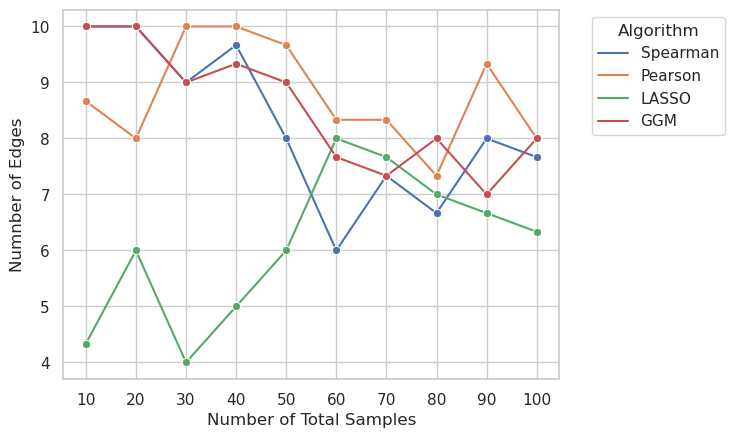

In [7]:

# Import pandas, seaborn and matplotlib.pyplot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# dataset_name = "amgut1"
dataset_name = "crohns"
# dataset_name = "ioral"

algorithm_dict = {
    "Spearman": f"{dataset_name}_Spearman_edges_sample.csv",
    "Pearson": f"{dataset_name}_Pearson_edges_sample.csv",
    "LASSO": f"{dataset_name}_LASSO_edges_sample.csv",
    "GGM": f"{dataset_name}_GGM_edges_sample.csv"
}


df = pd.concat([pd.read_csv(f"{algorithm_dict[algorithm]}") for algorithm in algorithm_dict.keys()])

# Import pandas, seaborn and matplotlib.pyplot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Set the style of the plot
sns.set(style="whitegrid")

# Plot the scatterplot with connecting lines
sns.lineplot(data=df, 
             x="n_total_samples", 
            #  y="n_edges", 
             y="mean_n_edges", 
             hue="algorithm", 
             marker="o", 
             hue_order=["Spearman", "Pearson", "LASSO", "GGM"])

# Set the x-axis ticks to match the n_total_samples values
plt.xticks(df["n_total_samples"].unique())

plt.xlabel("Number of Total Samples")
plt.ylabel("Numnber of Edges")
# plt.title("Plot of n_total_samples vs n_edges with Connecting Lines")
plt.legend(bbox_to_anchor=(1.05, 1), title="Algorithm")

plt.show()

In [15]:
df

,n_total_samples,mean_n_edges,std_n_edges,median_n_edges,min_n_edges,algorithm
0,289,3227.000000,326.219251,3117.0,2970,Spearman
1,145,1823.666667,1297.902282,2566.0,325,Spearman
0,289,4043.000000,1276.386697,3562.0,3077,Pearson
1,145,3263.333333,1389.655473,2547.0,2378,Pearson
0,289,1271.000000,15.132746,1266.0,1259,LASSO
1,145,864.000000,19.924859,853.0,852,LASSO
0,145,825.333333,11.590226,831.0,812,GGM
1,289,845.000000,35.000000,860.0,805,GGM


# Combining the three dataframes into one

In [ ]:

# Import pandas, seaborn and matplotlib.pyplot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dataset_name = "amgut1"
algorithm_dict = {
    "Spearman": f"{dataset_name}_Spearman_edges_sample.csv",
    "Pearson": f"{dataset_name}_Pearson_edges_sample.csv",
    "LASSO": f"{dataset_name}_LASSO_edges_sample.csv",
    "GGM": f"{dataset_name}_GGM_edges_sample.csv"
}
df1 = pd.concat([pd.read_csv(f"{algorithm_dict[algorithm]}") for algorithm in algorithm_dict.keys()])
df1['Dataset'] = dataset_name

dataset_name = "crohns"
algorithm_dict = {
    "Spearman": f"{dataset_name}_Spearman_edges_sample.csv",
    "Pearson": f"{dataset_name}_Pearson_edges_sample.csv",
    "LASSO": f"{dataset_name}_LASSO_edges_sample.csv",
    "GGM": f"{dataset_name}_GGM_edges_sample.csv"
}
df2 = pd.concat([pd.read_csv(f"{algorithm_dict[algorithm]}") for algorithm in algorithm_dict.keys()])
df2['Dataset'] = dataset_name


dataset_name = "ioral"
algorithm_dict = {
    "Spearman": f"{dataset_name}_Spearman_edges_sample.csv",
    "Pearson": f"{dataset_name}_Pearson_edges_sample.csv",
    "LASSO": f"{dataset_name}_LASSO_edges_sample.csv",
    "GGM": f"{dataset_name}_GGM_edges_sample.csv"
}
df3 = pd.concat([pd.read_csv(f"{algorithm_dict[algorithm]}") for algorithm in algorithm_dict.keys()])
df3['Dataset'] = dataset_name

df_grand = pd.concat([df1, df2, df3])

# save the dataframe to a csv file
df_grand.to_csv("amgut1_crohns_ioral_edges_sample_df_1.csv", index=False)

In [ ]:
df_grand


### Generate `Algorithm`, `Positive Association`, `Negative Association` and `Number of Edges` from the `source_target_weight` data

4265
5680
2393
1419


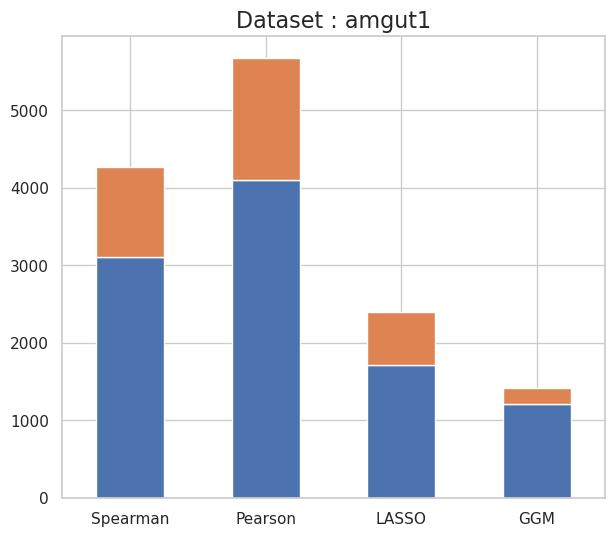

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset_name = "amgut1"
# dataset_name = "crohns"
# dataset_name = "ioral"

algorithm_dict = {
    "Spearman": f"{dataset_name}_Spearman_source_target.csv",
    "Pearson": f"{dataset_name}_Pearson_source_target.csv",
    "LASSO": f"{dataset_name}_LASSO_source_target.csv",
    "GGM": f"{dataset_name}_GGM_source_target.csv"
}

algo_edges_df_list = []
for algorithm, source_target_file in algorithm_dict.items():
    local_df = pd.read_csv(source_target_file)
    # create a new row as a dictionary
    new_row = {
        "Positive Association": local_df["weight"].value_counts().loc[lambda x: x.index > 0].sum(),
        "Negative Association": local_df["weight"].value_counts().loc[lambda x: x.index < 0].sum(),
        "Algorithm": algorithm}
    # use pandas.concat() to append the new row to an empty dataframe
    new_df = pd.concat([pd.DataFrame(), pd.DataFrame(new_row, index=[0])])
    # new_df["Number of Edges"] = local_df["weight"].count()
    print(local_df["weight"].count())
    algo_edges_df_list.append(new_df)

algo_edges_df = pd.concat(algo_edges_df_list)

# plot the stacked bar plot using matplotlib
sns.set(style="whitegrid")
ax = algo_edges_df.set_index('Algorithm').plot.bar(
    stacked=True, figsize=(7, 6))

# set the labels and title
# plt.xlabel("Algorithm")
# plt.ylabel("Number of Edges")
plt.xlabel("")
plt.ylabel("")
# plt.title("Number of Edges by Algorithm and Association")
plt.title(f"Dataset : {dataset_name}", fontsize=16)

# draw a horizontal line at y=8000
# ax.axhline(y=8128, color='red', linestyle='--')

# add a text annotation
# ax.text(x=0.5, y=8500, s='Maximum number of edges = 8128', color='red')

# make the x-axis labels horizontal
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# get handles and labels
# handles, labels = plt.gca().get_legend_handles_labels()
# order = [1, 0]
# plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])

# dont show the legend
plt.legend().remove()

# save the plot as a file
plt.savefig(f"{dataset_name}_edges_algo.svg", bbox_inches='tight')

# show the plot
plt.show()

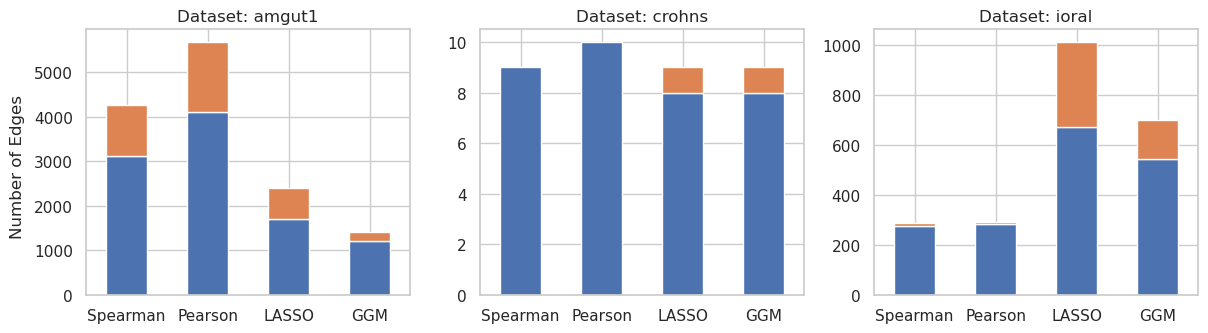

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset_names = ["amgut1", "crohns", "ioral"]

fig, axes = plt.subplots(1, 3, figsize=(7, 2))  # Create 3 subplots in a single row

for i, dataset_name in enumerate(dataset_names):
    algorithm_dict = {
        "Spearman": f"{dataset_name}_Spearman_source_target.csv",
        "Pearson": f"{dataset_name}_Pearson_source_target.csv",
        "LASSO": f"{dataset_name}_LASSO_source_target.csv",
        "GGM": f"{dataset_name}_GGM_source_target.csv"
    }

    algo_edges_df_list = []
    for algorithm, source_target_file in algorithm_dict.items():
        local_df = pd.read_csv(source_target_file)
        new_row = {
            "Positive Association": local_df["weight"].value_counts().loc[lambda x: x.index > 0].sum(),
            "Negative Association": local_df["weight"].value_counts().loc[lambda x: x.index < 0].sum(),
            "Algorithm": algorithm}
        new_df = pd.concat([pd.DataFrame(), pd.DataFrame(new_row, index=[0])])
        algo_edges_df_list.append(new_df)

    algo_edges_df = pd.concat(algo_edges_df_list)

    # Plot the stacked bar plot on the current subplot
    sns.set(style="whitegrid")
    ax = algo_edges_df.set_index('Algorithm').plot.bar(
        stacked=True, figsize=(12, 3.5), ax=axes[i])

    # Set the labels and title for the current subplot
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title(f"Dataset: {dataset_name}")

    # Make the x-axis labels horizontal
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    ax.legend().remove()

    # Get handles and labels
    # Update the legend for the final subplot
    
        
    # order = [1, 0]
    # ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order])


# get handles and labels


# Set the title for the entire plot
# fig.suptitle("Number of Edges against Algorithm for Necromass Species", fontsize=16)

# set y-axis label for the entire plot
fig.text(-0.005, 0.5, "Number of Edges", va='center', rotation='vertical')

# Adjust the spacing between subplots
plt.tight_layout()

plt.legend().remove()


# Save the plot
# plt.savefig('necromass_genus_edges_algo.png', bbox_inches='tight', dpi=1500)
# plt.savefig('necromass_species_edges_algo.png', bbox_inches='tight', dpi=1500)
# plt.savefig('necromass_conservative_edges_algo.png', bbox_inches='tight', dpi=1500)
plt.savefig(f"amgut1_crohns_ioral_edges_algo.svg", bbox_inches='tight')

# Show the plot
plt.show()
